# Practica 2

## Parte B

In [1]:
pip install scikit-learn

Primero, preparamos una funcion de generacion de datos aleatorios. En este caso, tenemos presion, colesterol y como el atributo tercero hemos seleccionado indice de masa corporal (BMI)

In [68]:
SEED = 123

In [69]:
import numpy as np
import pandas as pd

def generar_data(n_samples):
  np.random.seed(SEED)

  # genera datos de presion
  presion = np.random.randint(70, 180, n_samples)

  # genera datos de colesterol
  colesterol = np.random.randint(120, 250, n_samples)

  # genera datos de indice de masa corporal BMI
  bmi = np.random.uniform(15, 35, n_samples)
  return presion, colesterol, bmi

presion, colesterol, bmi = generar_data(800)
df = pd.DataFrame({'Presion': presion, 'Colesterol': colesterol, 'BMI': bmi})
df.head()

,Presion,Colesterol,BMI
0,179,123,32.996790
1,136,249,21.694050
2,162,229,20.433979
3,168,183,17.714186
4,172,148,31.627539


Estandartizamos los datos utilizando StandardScaler. La estandarizacion de los datos antes de LogisticRegression garantiza que todos los atributos contribuyan por igual, evita el predominio de atributos especificos.

In [70]:
# estandartizacion de datos
from sklearn.preprocessing import StandardScaler

def estandarizar(df):
  atributos = ['Presion', 'Colesterol', 'BMI']
  original = df[atributos]

  # utilizamos StandardScaler de sklearn
  scaler = StandardScaler()
  data_scaled = scaler.fit_transform(original)
  df_std = pd.DataFrame(data_scaled, columns=atributos)
  return df_std, data_scaled

df_std, data_scaled = estandarizar(df)
df_std.head()

,Presion,Colesterol,BMI
0,1.654061,-1.643702,1.368569
1,0.321671,1.678906,-0.554490
2,1.127303,1.151508,-0.768880
3,1.313217,-0.061508,-1.231628
4,1.437161,-0.984454,1.135604


Proximo, implementamos funcion para calcular riesgo de problemas vasculares. Para cada atributo (presion, colesterol, BMI), suma puntos segun rangos predefinidos (por ejemplo, mas bajos o mas altos que umbrales especificos), y los valores de riesgo mas altos tienen condiciones mas extremas. El score de riesgo total es la suma de estos puntos para cada individuo.

In [71]:
def calcular_riesgo(presion, colesterol, bmi):
  return sum([
    (presion < 100) + (121 <= presion <= 140) + 2 * (presion > 140),
    (180 <= colesterol <= 200) + 2 * (colesterol > 200),
    (25 <= bmi <= 30) + 2 * (bmi > 30)
  ])

# comprobamos si la suma total de factores resulta en riesgo de prblemas vasculares
df['Riesgo'] = df.apply(lambda row: calcular_riesgo(row['Presion'], row['Colesterol'], row['BMI']), axis=1)
df['Riesgo'] = (df['Riesgo'] >= 3).astype(int)
df.head()

,Presion,Colesterol,BMI,Riesgo
0,179,123,32.996790,1
1,136,249,21.694050,1
2,162,229,20.433979,1
3,168,183,17.714186,1
4,172,148,31.627539,1


Tambien hemos intendado calcular la probabilidad de riesgo de problemas de esta manera. Utilizando la funcion sigmoid:

```python
def generar_datos(n):
  presion_arterial = np.random.uniform(70, 180, n)  # Valores entre 70 y 180
  colesterol = np.random.uniform(120, 250, n)  # Valores entre 120 y 250
  edad = np.random.uniform(0, 100, n)  # Valores entre 0 y 100 (factor aleatorio)
  
  # Probabilidad de riesgo cardiovascular (estandarizar)
  # Se calcula los datos en base a los rangos aportados por la profesora.
  # Presión arterial, si esta por encima de 100.
  # Colesteron por encima de 180.
  # Se suman las probabilidades para definir el factor de riesgo.
  prob_riesgo = (presion_arterial - 100) / 100 + (colesterol - 180) / 100 + (edad - 50)/100
  # Se aplica la ecuación de la regresión logística.
  prob_riesgo = 1 / (1 + np.exp(-prob_riesgo))
  
  # Clasificación: 1 si la probabilidad es mayor a 0.5, 0 si es menor
  riesgo = (prob_riesgo > 0.5).astype(int)
  
  return np.column_stack((presion_arterial, colesterol, edad)), riesgo
```

Nos encontramos con el problema de que los diferentes valores considerados no tenian el mismo peso al calcular la probabilidad del riesgo.

Mostramos las diagramas, comparando diferentes parejas de atributos:

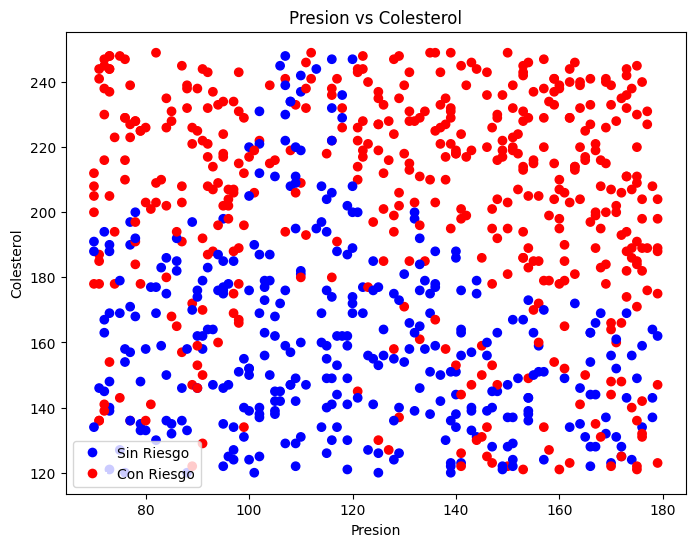

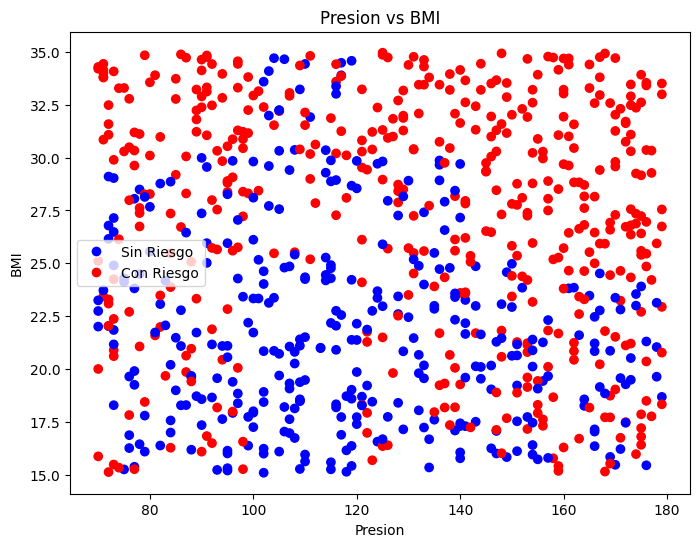

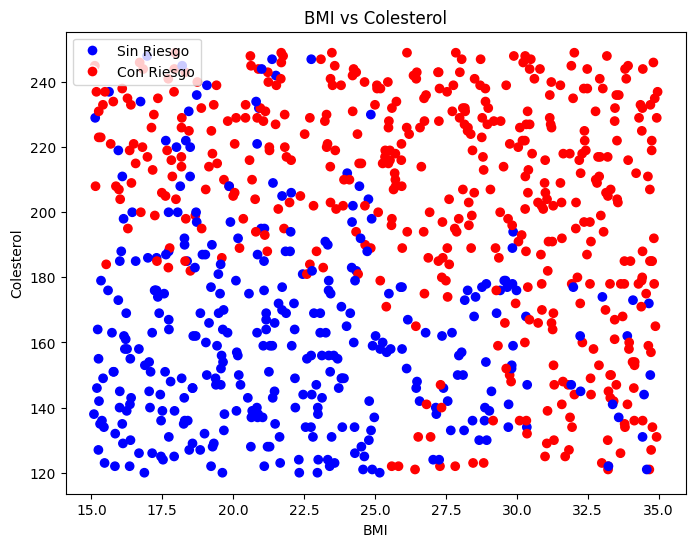

In [72]:
import matplotlib.pyplot as plt

colors = {0: 'blue', 1: 'red'}

# pares de atributos a comparar
feature_pairs = [('Presion', 'Colesterol'), ('Presion', 'BMI'), ('BMI', 'Colesterol')]

# dibuja graficos de cada par, incluyendo problemas potenciales
for x_feature, y_feature in feature_pairs:
  plt.figure(figsize=(8, 6))
  plt.scatter(df[x_feature], df[y_feature], c=df['Riesgo'].map(colors))
  plt.xlabel(x_feature)
  plt.ylabel(y_feature)
  plt.title(f'{x_feature} vs {y_feature}')
  plt.legend(handles=[
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Sin Riesgo'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=8, label='Con Riesgo')
  ])
  plt.show()

Podemos ver, que personas con mas factores cumpliendo (presion fuera de rango normal, alto colesterol y BMI) tienen mayor riesgo de problemas vasculares. Por eso, mayoria de puntos con problemas (con riesgo) tambien estan distribuidos en rangos problematicos de presion y colesterol.

Ahora, utilizamos estos datos para entrenar modelo LogisticRegression.

In [76]:
# separar datos normalizados en entrenamiento y evaluacion
from sklearn.model_selection import train_test_split

y = df['Riesgo']

# utilizaremos para el entrenamiento los datos estandartizados
X_train, X_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.25, random_state=SEED)

In [77]:
from sklearn.linear_model import LogisticRegression

# entrenar model
model = LogisticRegression()
model.fit(X_train, y_train)

# summary de model
print(model.coef_)
print(model.intercept_)

[[0.93181836 2.14874102 1.81489646]]
[0.72737122]


In [78]:
from sklearn.metrics import accuracy_score

# predicciones
y_pred = model.predict(X_test)
print(y_pred[:10])

# precision de predicciones
accuracy = accuracy_score(y_test, y_pred)
print(f"Precision: {accuracy}")

[1 1 1 0 0 0 1 0 0 0]
Precision: 0.835


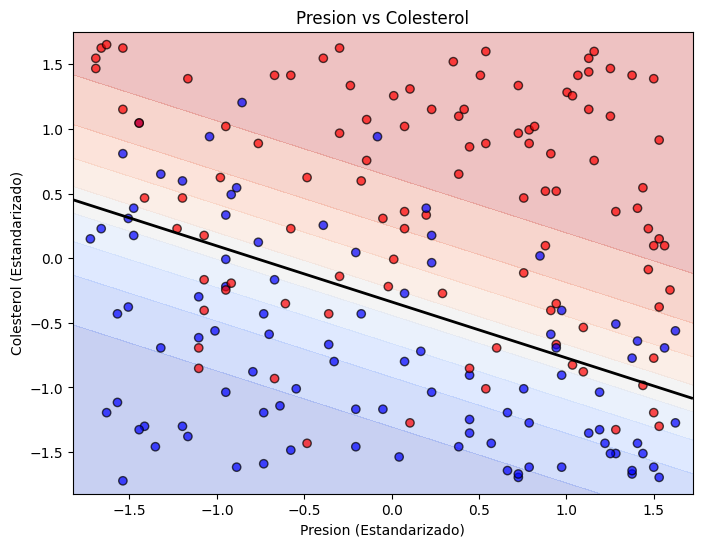

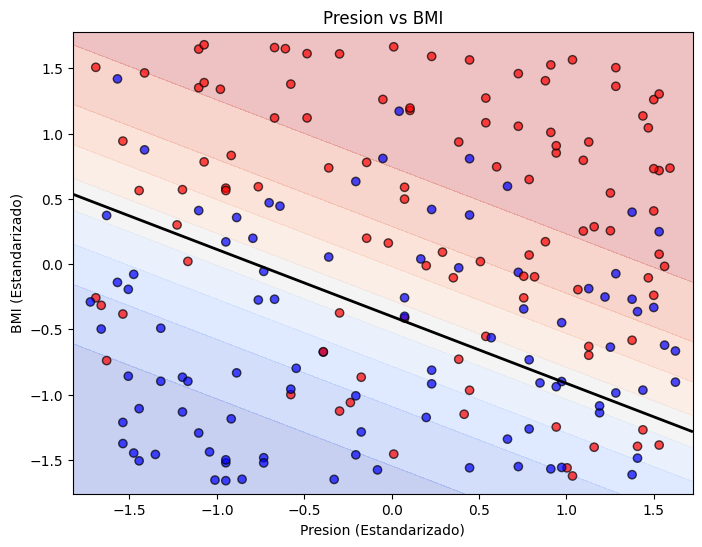

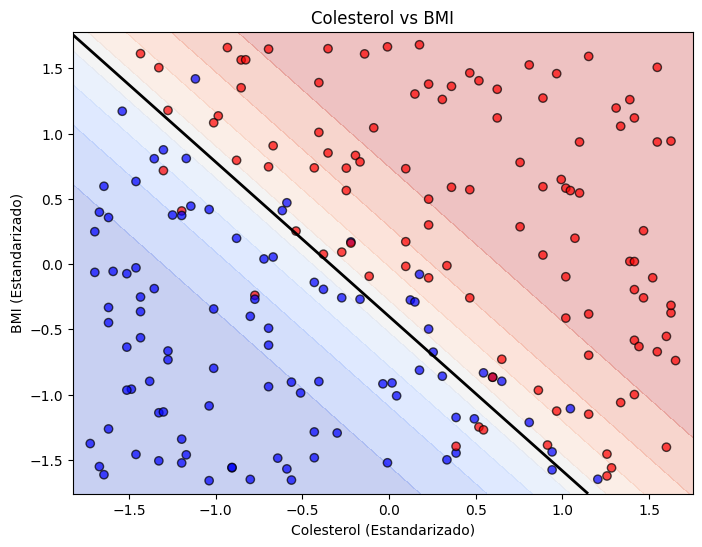

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def plot_regression_logistica(model, X_test, y_pred):
  # pares de atributos a graficar
  feature_pairs = [
    (0, "Presion", 1, "Colesterol"),
    (0, "Presion", 2, "BMI"),
    (1, "Colesterol", 2, "BMI")
  ]

  for x_idx, x_label, y_idx, y_label in feature_pairs:
    plt.figure(figsize=(8, 6))

    # creamos un grid
    x_min, x_max = X_test[:, x_idx].min() - 0.1, X_test[:, x_idx].max() + 0.1
    y_min, y_max = X_test[:, y_idx].min() - 0.1, X_test[:, y_idx].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    # para cada pareja, ignoramos el atributo tercero, lo ponemos a 0 (mean value)
    grid = np.zeros((xx.ravel().shape[0], X_test.shape[1]))
    grid[:, x_idx] = xx.ravel()
    grid[:, y_idx] = yy.ravel()

    # prediccion de probabilidades
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    # curva de regression para separar clases (con regiones colorados)
    plt.contourf(xx, yy, probs, levels=np.linspace(0, 1, 10), cmap='coolwarm', alpha=0.3)
    plt.contour(xx, yy, probs, levels=[0.5], linewidths=2, colors='black')

    # resultados predichos actuales
    plt.scatter(X_test[:, x_idx], X_test[:, y_idx], c=y_pred, cmap='bwr', edgecolor='k', alpha=0.7)

    plt.xlabel(f'{x_label} (Estandarizado)')
    plt.ylabel(f'{y_label} (Estandarizado)')
    plt.title(f'{x_label} vs {y_label}')
    plt.show()

plot_regression_logistica(model, X_test, y_pred)

Podemos ver, que la curva de regression separa individuos con/sin riesgo es bastance precisa. Aunque hay algunos outliers, la mayoria de puntos estan en sus zonas predichas. La explicacion potencial para esto puede ser que no tenemos bastante individuos para hacer las predicciones mas precisas. Puede depender del metodo que utilizamos para obtener la probabilidad de problemas vasculares.

Entrenamos con el conjunto de 500 personas:

In [80]:
# generamos nuevo dataset
presion, colesterol, bmi = generar_data(500)

df_2 = pd.DataFrame({'Presion': presion, 'Colesterol': colesterol, 'BMI': bmi})
df_2.head()

,Presion,Colesterol,BMI
0,179,142,18.173583
1,136,166,23.398463
2,162,169,19.924858
3,168,241,19.106995
4,172,128,28.696517


In [58]:
# estandartizamos nuevo dataset
df_2_std, data_2_scaled = estandarizar(df_2)
df_2_std.head()

,Presion,Colesterol,BMI
0,1.566001,-1.059122,-1.069189
1,0.268693,-0.431959,-0.180184
2,1.053112,-0.353563,-0.771212
3,1.234132,1.527927,-0.910370
4,1.354811,-1.424967,0.721271


In [59]:
# calculamos riesgo de problemas vasculares para el nuevo dataset
df_2['Riesgo'] = df_2.apply(lambda row: calcular_riesgo(row['Presion'], row['Colesterol'], row['BMI']), axis=1)
df_2['Riesgo'] = (df_2['Riesgo'] >= 3).astype(int)
df_2.head()

,Presion,Colesterol,BMI,Riesgo
0,179,142,18.173583,0
1,136,166,23.398463,0
2,162,169,19.924858,0
3,168,241,19.106995,1
4,172,128,28.696517,1


In [66]:
from sklearn.metrics import accuracy_score

y = df_2['Riesgo']

# predicciones
y_pred_2 = model.predict(data_2_scaled)
print(y_pred_2[:10])

# precision de predicciones
accuracy = accuracy_score(y, y_pred_2)
print(f"Accuracy: {accuracy}")

[0 0 0 1 1 1 1 1 1 1]
Accuracy: 0.848


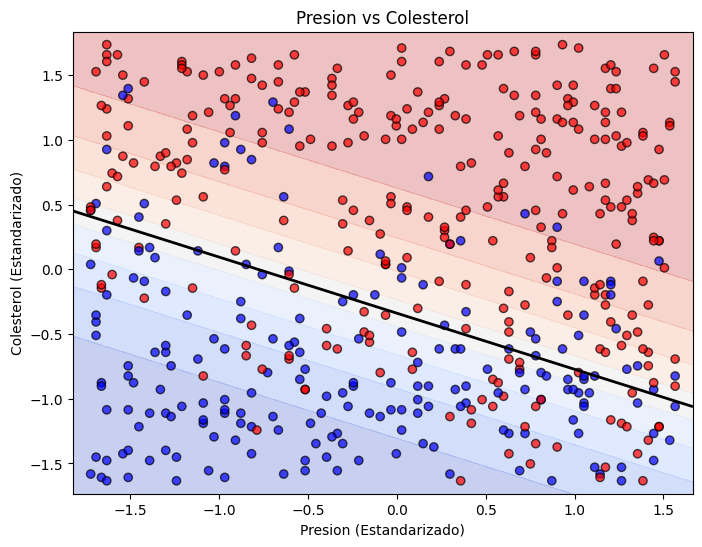

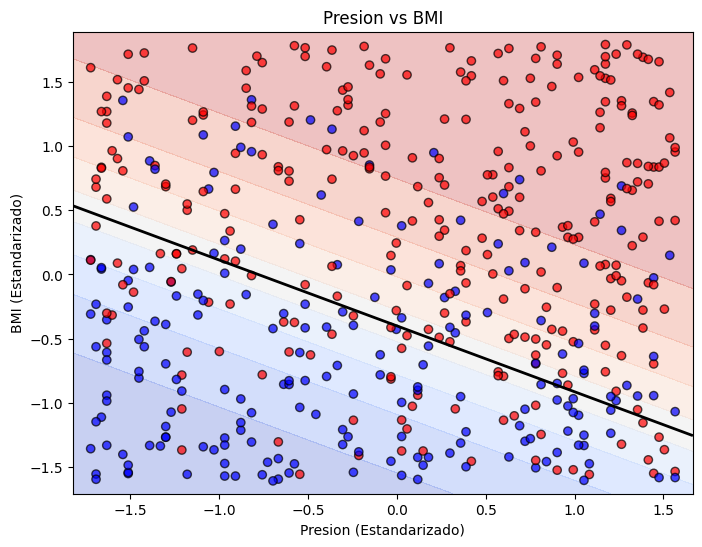

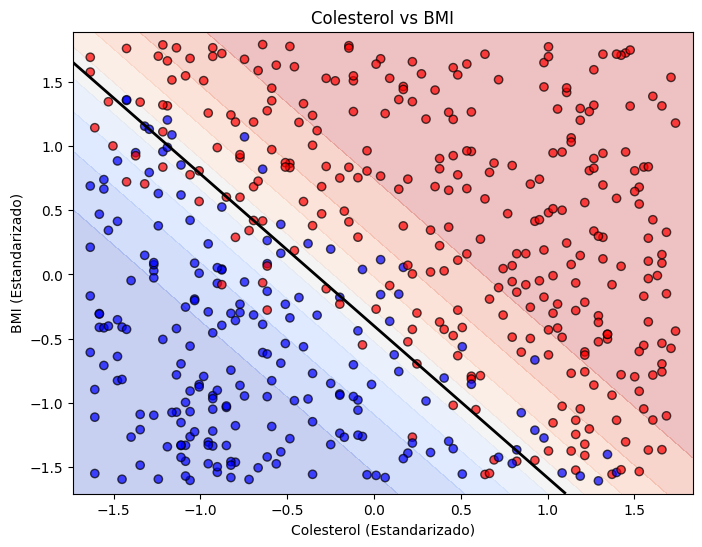

In [67]:
plot_regression_logistica(model, data_2_scaled, y_pred_2)

Al utilizar el modelo LogisticRegression con nuevos 500 individuos, podemos ver que la precion a subido un poco (de ~0.83 -> ~0.85).